In [ ]:
from rebinning import station_radii, draw_wheels, make_concentric_disks, make_disk, station3_boundaries, rebin
from utilities import Show2Dimg
import numpy as np
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from utilities import *
from ResNet_VAE import ResNetVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

### Load the images and apply rebinning

In [ ]:
dir = "/eos/cms/store/group/ml/AD4MVDHackathon/ML4DQM_MUON/anomalies/"
file = "hRHGlobalm2_300724_s3_bad.npz"
data = np.load(dir+file)
imgs = data['imgs']

In [ ]:
#hole to mask the non-relevant inner and outer parts
empty_img = np.zeros((100,100), dtype=np.int16)
#station3 boundaries are good for station2 as well
inner_radius, outer_radius = station3_boundaries()
hole = make_disk(empty_img, inner_radius,1.)
hole = np.abs(hole-1)
hole *= make_disk(empty_img, outer_radius,1.)

##### Example: image without/with hole

In [ ]:
Show2Dimg(imgs[0], title="Original")
Show2Dimg(imgs[0]*hole, title="Masked")

In [ ]:
slices = draw_wheels(50,3)
conc_disks = make_concentric_disks(50,station_radii(2))
regions = slices * conc_disks * hole

#### rebin images

In [ ]:
rebinned_imgs = np.array([rebin(regions, img) for img in imgs])


#### data agumentation 

In [ ]:
selected_chamber = []

for image in rebinned_imgs:
    selected_chamber.append(image)  # original image
    for _ in range(3):  # 3 rotations of 90 degrees
        image = np.rot90(image)
        selected_chamber.append(image)

selected_chamber = np.array(selected_chamber)

##### see an example of data augmentation

In [ ]:
#index should be a multiple of 4, e.g. 0, 4, 8
index = 0
index = index - index % 4
Show2Dimg(selected_chamber[index], title="First image")
Show2Dimg(selected_chamber[index+1], title="Rotated by 90 degrees")
Show2Dimg(selected_chamber[index+2], title="Rotated by 180 degrees")
Show2Dimg(selected_chamber[index+3], title="Rotated by 270 degrees")

#### Normalization: (I have no idea why but without this it all breaks)

In [ ]:
norm = 0.01
for img in selected_chamber:
    img *= norm

##### Mean Matrix

In [ ]:
mean_matrix = np.mean(selected_chamber, axis=0)
Show2Dimg(mean_matrix)
mean_matrix[mean_matrix == 0] = np.nan

### Training the VAE

In [ ]:
training_tensor = [
    (torch.tensor(m, dtype=torch.float32)).unsqueeze(0) for m in selected_chamber
]
print(f"Total images used for training: {len(training_tensor)}")

training_loader = DataLoader(
    dataset=training_tensor, batch_size=64, num_workers=10, shuffle=True
)

In [ ]:
def VAE_loss (Xreco, X, mean, logvar, beta):
    # Reconstruction loss
    recon_loss = F.l1_loss(Xreco, X)
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

#### $\beta$ annealing

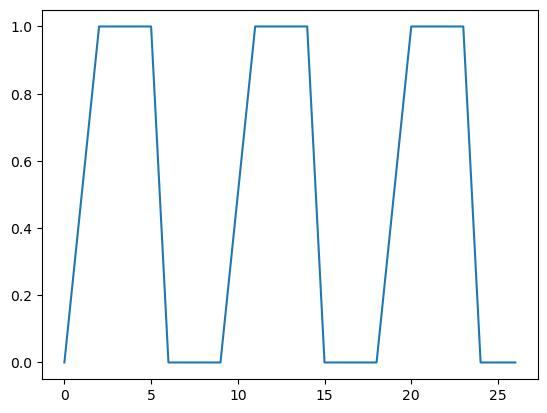

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def generate_betas(low_value, max_value, cycles, epochs):
    cycle_length = epochs // cycles
    third_cycle = cycle_length // 3

    # Generate linear rise for first third of the cycle
    first_third = np.linspace(low_value, max_value, third_cycle)

    # Generate constant high value for second third of the cycle
    second_third = np.full(third_cycle, max_value)

    # Generate constant low value for last third of the cycle
    last_third = np.full(third_cycle, low_value)

    # Combine to form a complete cycle
    cycle = np.concatenate((first_third, second_third, last_third))

    # Repeat the cycle for the number of cycles
    betas = np.tile(cycle, cycles)

    # If epochs is not a multiple of cycle_length, append additional values
    if epochs % cycle_length != 0:
        extra_values = np.full(epochs % cycle_length, low_value)
        betas = np.concatenate((betas, extra_values))

    return betas

epochs = 30

# Define the parameters
low_value = 1e-10
max_value = 1
cycles = 3

# Generate the betas
betas = generate_betas(low_value, max_value, cycles, epochs)

#plot them
plt.plot(betas)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Constants
LR = 1.e-5
FACTOR = 0.1
PATIENCE = 2
THRESHOLD = 0.05
VERBOSE = True
BATCH_PRINT_INTERVAL = 38

# Initialize the model, optimizer and scheduler
img_size = list(tensor_list[0].squeeze(0).size())
ae = ResNetVAE(1, 3, [2**x for x in [5,6,7,8]], img_size=img_size, device=device, latent_size=2**9).to(device)
optimizer = optim.Adam(ae.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=FACTOR, patience=PATIENCE, threshold=THRESHOLD, verbose=VERBOSE)

train_loss, val_loss =[], []

def train_model(epoch, training_loader):
    print(f'***** Training Epoch {epoch} *****')
    ae.train()
    now = time.time()
    tloss=[]
    for i, figure in enumerate(training_loader):
        X = figure.to(device)
        optimizer.zero_grad()
        Xreco, mean, logvar = ae(X)
        beta=betas[epoch-1]
        loss, l1_loss, kl_loss = VAE_loss(Xreco, X, mean, logvar, beta)
        tloss.append(loss.item())
        loss.backward()
        optimizer.step()
        if i % BATCH_PRINT_INTERVAL == 0:
            print(f'>> [{i}/{len(training_loader)}] Train loss:{loss.item()}')
            print(f'>> L1 loss:{l1_loss.item()} | KL loss:{kl_loss.item()}')
    train_loss.append(np.mean(tloss))
    now = time.time() - now
    s = '>> Training time: %.2f min in %d steps'%( now/60, len(training_loader))
    print(s)
    scheduler.step(np.mean(tloss))

# Training loop
for e in range(epochs):
    train_model(e+1, training_loader)

In [ ]:
for i, img in enumerate(training_loader):
    img = img.to(device)
    reco_img, mean, logvar = ae(img)
    print(f"***** batch {i} *****")
    for k in range(4):
        print(f" >> Example {k}")
        Show2Dimg(img[k][0].cpu().numpy(), title="Original")
        Show2Dimg(reco_img[k][0].detach().cpu().numpy(), title=f"Reconstructed, $\mu$={mean[k].detach().cpu().numpy()}, $\log(\sigma^2)$={logvar[k].detach().cpu().numpy()}")
    
    if i > 5: 
        break